# Reflection

We'll implement **reflection** using a graph with two main nodes:

- `generate`: Responsible for **writing or revising** drafts of a three-paragraph essay.
- `reflect`: Writes a **critique** of the generated essay to guide the next revision.

---

### Workflow

The graph will run in a **looped sequence** where:

1. `generate` produces an essay draft or revision.
2. `reflect` analyzes the output and suggests improvements.
3. The process repeats for a **fixed number of iterations**.

> Note: A more advanced variation of this technique would allow the `reflect` node to decide **when to stop**, making the process adaptive.

---

### Next Step

Let’s take a look at how this graph is structured and what the implementation looks like.



In [ ]:
# https://langchain-ai.github.io/langgraph/tutorials/reflection/reflection/#repeat
from typing import Annotated, TypedDict

from langchain_core.messages import (
    AIMessage,
    HumanMessage,
)
from langchain_openai import AzureChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver

from utils import graph_to_image

model = AzureChatOpenAI(
    azure_deployment="gpt-4o",
    api_version="2024-10-21",
)

class State(TypedDict):
    messages: Annotated[list, add_messages]

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an essay assistant tasked with writing excellent 5-paragraph essays."
            " Generate the best essay possible for the user's request."
            " If the user provides critique, respond with a revised version of your previous attempts.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

generate = prompt | model

def generation_node(state: State) -> State:
    return {"messages": [generate.invoke(state["messages"])]}

reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a teacher grading an essay submission. Generate critique and recommendations for the user's submission."
            " Provide detailed recommendations, including requests for length, depth, style, etc.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
reflect = reflection_prompt | model

def reflection_node(state: State) -> State:
    # Other messages we need to adjust
    cls_map = {"ai": HumanMessage, "human": AIMessage}
    # First message is the original user request. We hold it the same for all nodes
    translated = [state["messages"][0]] + [
        cls_map[msg.type](content=msg.content) for msg in state["messages"][1:]
    ]
    res = reflect.invoke(translated)
    # We treat the output of this as human feedback for the generator
    return {"messages": [HumanMessage(content=res.content)]}

builder = StateGraph(State)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_edge(START, "generate")


def should_continue(state: State):
    if len(state["messages"]) > 6:
        # End after 3 iterations, each with 2 messages
        return END
    return "reflect"

builder.add_conditional_edges("generate", should_continue)
builder.add_edge("reflect", "generate")
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

Graph image saved to ../img/graph_reflection.png


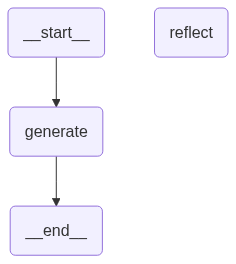

In [9]:
graph_to_image(graph, "graph_reflection.png")

### Design Notes on the Reflect-Generate Loop

#### Message Framing

An important aspect of this architecture is how we **frame the conversation** for the LLM:

- The `reflect` node is set up to **pretend it's critiquing essays written by the user**.
- The `generate` node, in turn, is led to believe that the **critique comes from the user**.

This design choice is intentional. Most dialogue-tuned LLMs are trained on **alternating pairs** of human and AI messages.  
Allowing one role to speak for multiple turns in a row can lead to **degraded performance**.  
By alternating the roles, we maintain alignment with the LLM's training format.

---

#### Loop Termination

You might expect the loop to end after a `reflect` step—but in this architecture, we:

- Run a **fixed number of iterations** of the `generate`–`reflect` loop.
- **Terminate after a final `generate` step**, allowing the last set of critique comments to be incorporated.

> An alternate design could let the `reflect` node **decide when to stop** the process once no further improvements are suggested.

---

### Next: A Sample Critique Output

Let’s take a look at what one of the critiques generated by the `reflect` node looks like.


In [10]:
config = {"configurable": {"thread_id": "1"}}
for event in graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Generate an essay on the topicality of The Little Prince and its message in modern life"
            )
        ],
    },
    config,
):
    print(event)
    print("---")

{'generate': {'messages': [AIMessage(content='**The Timeless Relevance of *The Little Prince* in Modern Life**\n\nAntoine de Saint-Exupéry’s *The Little Prince* is more than a children’s book; it is a profound allegory of human experience that transcends age and cultural boundaries. First published in 1943, this poetic novella explores themes of love, loss, imagination, and the search for meaning. In today’s fast-paced, digitalized world, the lessons of *The Little Prince* are more relevant than ever. Its gentle critique of materialism, reminder of the importance of relationships, and call to nurture one’s sense of wonder resonate deeply with the challenges of contemporary life.\n\nOne of the central messages of *The Little Prince* is its critique of the adult obsession with materialism and productivity. Through encounters with the grown-ups on different planets—the businessman obsessed with counting stars, the vain man craving admiration, and the king obsessed with control—the book de

In [11]:
state = graph.get_state(config)

In [12]:
ChatPromptTemplate.from_messages(state.values["messages"]).pretty_print()

================================ Human Message =================================

Generate an essay on the topicality of The Little Prince and its message in modern life

================================== Ai Message ==================================

**The Timeless Relevance of *The Little Prince* in Modern Life**

Antoine de Saint-Exupéry’s *The Little Prince* is more than a children’s book; it is a profound allegory of human experience that transcends age and cultural boundaries. First published in 1943, this poetic novella explores themes of love, loss, imagination, and the search for meaning. In today’s fast-paced, digitalized world, the lessons of *The Little Prince* are more relevant than ever. Its gentle critique of materialism, reminder of the importance of relationships, and call to nurture one’s sense of wonder resonate deeply with the challenges of contemporary life.

One of the central messages of *The Little Prince* is its critique of the adult obsession with materialism

Save the result in a markdown file:

In [13]:
with open("../results/essay.md", "w") as file:
    file.write(
        ChatPromptTemplate.from_messages(state.values["messages"]).format(
            messages=state.values["messages"]
        )
    )
print("Essay saved to ../results/essay.md")

Essay saved to ../results/essay.md


### Reflection and Its Variations

This simple form of reflection can often **enhance output quality** by:

- Giving the LLM **multiple attempts** to revise its work.
- Allowing the `reflect` node to **adopt a distinct persona**, improving the objectivity of critique.

---

### Architectural Variations

There are several ways to extend or modify the reflection loop:

#### 1. Combine with Agent Architecture

You can integrate reflection into the **agent architecture** described before by:

- Inserting the `reflect` node as the **final step before output** is returned to the user.
- This would make the critique **appear to come from the user**, and give the system an opportunity to improve its response.

**Tradeoff**: This approach may increase **latency**, as it adds another LLM call before final output.

---

#### 2. Ground the Critique with External Information

In some applications, it’s useful to **support the reflection** with external signals.  
For example, in a **code-generation agent**, you could:

- Add a step **before** `reflect` that runs the generated code through a **linter** or **compiler**.
- Use the **diagnostics or error messages** as part of the input to the `reflect` node.

This grounding can help make the reflection more accurate and actionable.

---

Let's go back to the [README file](../README.md/#calling-a-subgraph-directly)